In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
import random
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score, f1_score
from prettytable import PrettyTable
from sklearn.metrics import roc_auc_score, classification_report
from sklearn.metrics import plot_roc_curve
from sklearn.model_selection import GridSearchCV

### Import Dataset

The dataset used in this project was obtained from Kaggle. 

https://www.kaggle.com/datasets/fedesoriano/heart-failure-prediction

The dataset was created by combining different datasets that were already available, but had not been combined before. They were combined over 11 common features , making the final dataset at 918 observations.

* Age: age of the patient [years]
* Sex: sex of the patient [M: Male, F: Female]
* ChestPainType: chest pain type [TA: Typical Angina, ATA: Atypical Angina, NAP: Non-Anginal Pain, ASY: Asymptomatic]
* RestingBP: resting blood pressure [mm Hg]
* Cholesterol: serum cholesterol [mm/dl]
* FastingBS: fasting blood sugar [1: if FastingBS > 120 mg/dl, 0: otherwise]
* RestingECG: resting electrocardiogram results [Normal: Normal, ST: having ST-T wave abnormality (T wave inversions and/or ST elevation or depression of > 0.05 mV), LVH: showing probable or definite left ventricular hypertrophy by Estes' criteria]
* MaxHR: maximum heart rate achieved [Numeric value between 60 and 202]
* ExerciseAngina: exercise-induced angina [Y: Yes, N: No]
* Oldpeak: oldpeak = ST [Numeric value measured in depression]
* ST_Slope: the slope of the peak exercise ST segment [Up: upsloping, Flat: flat, Down: downsloping]
* HeartDisease: output class [1: heart disease, 0: Normal]

In [3]:
heart = pd.read_csv("heart.csv", skipinitialspace = True)

In [4]:
heart.head(5)

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0


### Data Preprocessing

#### Look at the column types and ensure they are correct

In [5]:
heart.dtypes

Age                 int64
Sex                object
ChestPainType      object
RestingBP           int64
Cholesterol         int64
FastingBS           int64
RestingECG         object
MaxHR               int64
ExerciseAngina     object
Oldpeak           float64
ST_Slope           object
HeartDisease        int64
dtype: object

#### Converting object to categorical

In [6]:
for col in ["Sex", "ChestPainType", "FastingBS", "RestingECG", 
            "ExerciseAngina", "ST_Slope"]:
    heart[col].astype("category")

#### Looking at the null values

In [7]:
heart.isnull().sum()

Age               0
Sex               0
ChestPainType     0
RestingBP         0
Cholesterol       0
FastingBS         0
RestingECG        0
MaxHR             0
ExerciseAngina    0
Oldpeak           0
ST_Slope          0
HeartDisease      0
dtype: int64

We have no null values in the dataset

## Data Exploration

#### Description of continuous variables for respondents with heart disease

In [14]:
heart[heart['HeartDisease']==1].describe()

,Age,RestingBP,Cholesterol,FastingBS,MaxHR,Oldpeak,HeartDisease
count,508.000000,508.000000,508.000000,508.000000,508.000000,508.000000,508.0
mean,55.899606,134.185039,175.940945,0.334646,127.655512,1.274213,1.0
std,8.727056,19.828685,126.391398,0.472332,23.386923,1.151872,0.0
min,31.000000,0.000000,0.000000,0.000000,60.000000,-2.600000,1.0
25%,51.000000,120.000000,0.000000,0.000000,112.000000,0.000000,1.0
50%,57.000000,132.000000,217.000000,0.000000,126.000000,1.200000,1.0
75%,62.000000,145.000000,267.000000,1.000000,144.250000,2.000000,1.0
max,77.000000,200.000000,603.000000,1.000000,195.000000,6.200000,1.0


Looking at our description of the dataset for respondents with heart disease, we see that the minimum age is 31, while the highest age is 77. For Max heart rate, we see that the highest rate is 195 beats per minute, and the lowest heart rate is 60 beats per minute. We have 508 respondents with heart disease. The average max heart rate was 127.66 beats per minute.

#### Description of continuous variables for respondents with heart disease

In [17]:
heart[heart['HeartDisease']==0].describe()

,Age,RestingBP,Cholesterol,FastingBS,MaxHR,Oldpeak,HeartDisease
count,410.000000,410.000000,410.000000,410.000000,410.000000,410.000000,410.0
mean,50.551220,130.180488,227.121951,0.107317,148.151220,0.408049,0.0
std,9.444915,16.499585,74.634659,0.309894,23.288067,0.699709,0.0
min,28.000000,80.000000,0.000000,0.000000,69.000000,-1.100000,0.0
25%,43.000000,120.000000,197.250000,0.000000,134.000000,0.000000,0.0
50%,51.000000,130.000000,227.000000,0.000000,150.000000,0.000000,0.0
75%,57.000000,140.000000,266.750000,0.000000,165.000000,0.600000,0.0
max,76.000000,190.000000,564.000000,1.000000,202.000000,4.200000,0.0


Looking at our description of the dataset for respondents with heart disease, we see that the minimum age is 28, while the highest age is 76. For Max heart rate, we see that the highest rate is 202 beats per minute, and the lowest heart rate is 69 beats per minute. We have 410 respondents without heart disease. The average max heart rate was 148.15 beats per minute.

#### Distribution of Age

<AxesSubplot:xlabel='Age', ylabel='Count'>

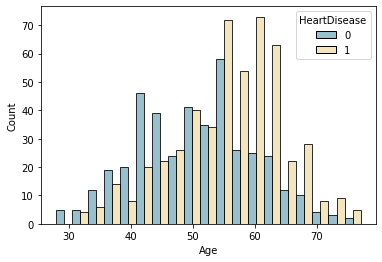

In [9]:
sns.histplot(heart, x = "Age", hue = "HeartDisease", stat = 'count',
             multiple = 'dodge', palette = "blend:#7AB,#EDA")


In the distribution of heart disease by age, we see that heart disease is more prevalent in older patients, while younger patients do not have heart disease as often. An interesting data point is at age 50, we see almost an equal amount of adults with or without heart disease.

#### Distribution of Heart Disease and Sex

<AxesSubplot:xlabel='Sex', ylabel='Count'>

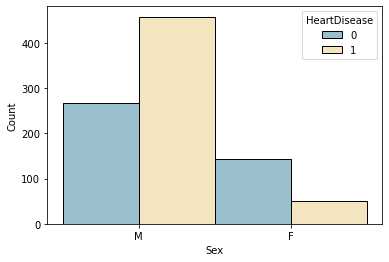

In [10]:
sns.histplot(heart, x = "Sex", hue = "HeartDisease", stat = 'count',
             multiple = 'dodge', palette = "blend:#7AB,#EDA")

We see that heart disease is more prevalent in men than women. In females, while we have less respondents who are female, heart disease was no as prevelent.

#### Distribution of HeartDisease and MaxHR

<AxesSubplot:xlabel='MaxHR', ylabel='Count'>

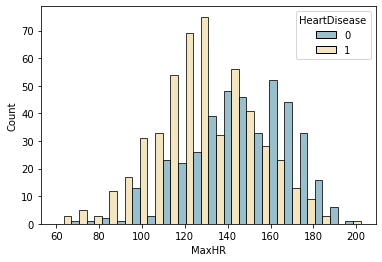

In [11]:
sns.histplot(heart, x = "MaxHR", hue = "HeartDisease", stat = 'count',
             multiple = 'dodge', palette = "blend:#7AB,#EDA")

Looking at the distribution between heart rates and heart disease, we can see that heart disease tends to have a maximum heart around 120 and then peaks again around 140. Respondents without heart disease had a higher range of maxiumum heart rates

#### Correlation between the target and continuous variables

                   Age  RestingBP  Cholesterol  FastingBS     MaxHR   Oldpeak  \
Age           1.000000   0.254399    -0.095282   0.198039 -0.382045  0.258612   
RestingBP     0.254399   1.000000     0.100893   0.070193 -0.112135  0.164803   
Cholesterol  -0.095282   0.100893     1.000000  -0.260974  0.235792  0.050148   
FastingBS     0.198039   0.070193    -0.260974   1.000000 -0.131438  0.052698   
MaxHR        -0.382045  -0.112135     0.235792  -0.131438  1.000000 -0.160691   
Oldpeak       0.258612   0.164803     0.050148   0.052698 -0.160691  1.000000   
HeartDisease  0.282039   0.107589    -0.232741   0.267291 -0.400421  0.403951   

              HeartDisease  
Age               0.282039  
RestingBP         0.107589  
Cholesterol      -0.232741  
FastingBS         0.267291  
MaxHR            -0.400421  
Oldpeak           0.403951  
HeartDisease      1.000000  


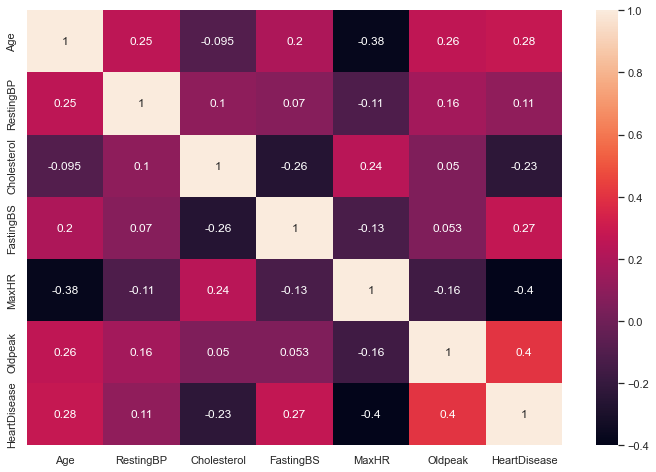

In [12]:
corrMatrix = heart.corr()
print (corrMatrix)
sns.set(rc={"figure.figsize":(12, 8)})
sns.heatmap(corrMatrix, annot=True)
plt.show()

In the correlation heatmap, the top two correlations with HeartDisease are Oldpeak (0.4), Age (0.28). MaxHR has the strongest negative correlation with HeartDisease (-0.4)

### 3-D plot for respondents with HeartDisease for Age, Oldpeak, and MaxHR

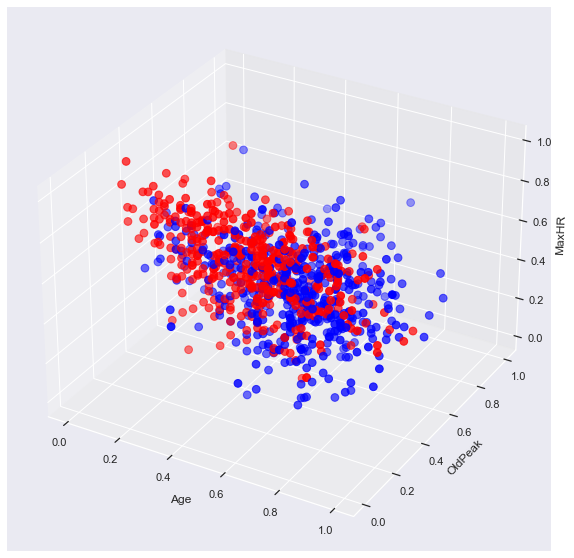

In [77]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')
colors = {0: 'red',1:'blue'}
ax.scatter(heart['Age'], heart['Oldpeak'], heart['MaxHR'], s=60, c = heart['HeartDisease'].map(colors))
ax.set_xlabel('Age')
ax.set_ylabel('OldPeak')
ax.set_zlabel('MaxHR')
plt.show()

#### Pairplot utilizing Oldpeak, Age, and MaxHR vs HeartDisease

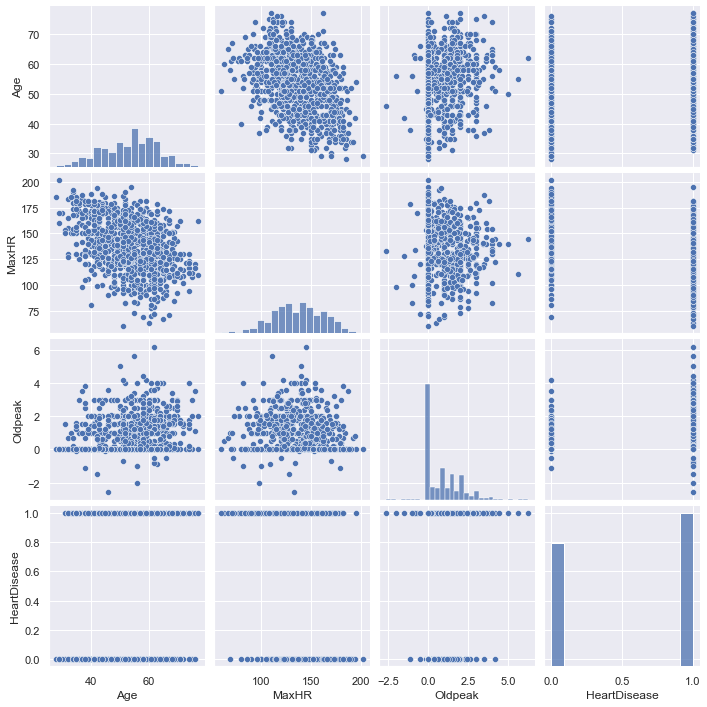

In [18]:
temp = heart[['Age', 'MaxHR', 'Oldpeak', 'HeartDisease']]
sns.pairplot(data = temp)
plt.show()

#### Scaling the data via MinMaxScalar

We are chosing a MinMaxScalar since our target variable 'HeartDisease' is 0 or 1 (binary).

In [19]:
for col in ["Age", "RestingBP", "Cholesterol", "MaxHR", "Oldpeak"]:
    arr = np.array(heart[col])
    scaler = MinMaxScaler()
    scaler.fit(arr.reshape(-1,1))
    heart[col]=scaler.transform(arr.reshape(-1,1))

#### Get Dummy Variables for Categorical Data

We are creating dummy variables for the categorical columns.

In [20]:
heartdf = pd.get_dummies(data=heart, columns=["Sex", "ChestPainType", "RestingECG", "ST_Slope"])
heartdf['ExerciseAngina'].replace({'N': 0, 'Y': 1}, inplace = True)
heartdf.head(5)

,Age,RestingBP,Cholesterol,FastingBS,MaxHR,ExerciseAngina,Oldpeak,HeartDisease,Sex_F,Sex_M,ChestPainType_ASY,ChestPainType_ATA,ChestPainType_NAP,ChestPainType_TA,RestingECG_LVH,RestingECG_Normal,RestingECG_ST,ST_Slope_Down,ST_Slope_Flat,ST_Slope_Up
0,0.244898,0.70,0.479270,0,0.788732,0,0.295455,0,0,1,0,1,0,0,0,1,0,0,0,1
1,0.428571,0.80,0.298507,0,0.676056,0,0.409091,1,1,0,0,0,1,0,0,1,0,0,1,0
2,0.183673,0.65,0.469320,0,0.267606,0,0.295455,0,0,1,0,1,0,0,0,0,1,0,0,1
3,0.408163,0.69,0.354892,0,0.338028,1,0.465909,1,1,0,1,0,0,0,0,1,0,0,1,0
4,0.530612,0.75,0.323383,0,0.436620,0,0.295455,0,0,1,0,0,1,0,0,1,0,0,0,1


## Data Model
Building the model. We will be testing 4 models, RandomForestClassifier, KNeighborsClassifier, LogisticRegression, and DecisionTreeClassifier. Our target variable will be HeartDisease. Focusing on F1 score, since False Positives/False Negatives are important in the model. 

#### Splitting the dataset into train, test sets. I will be utiliizing a 70/30 split

In [21]:
# Train Test Split with 30%
y = heartdf['HeartDisease']
X = heartdf.drop('HeartDisease', axis = 1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

#### Running the models, utilizing the RSME.

In [22]:
models = [DecisionTreeClassifier(), RandomForestClassifier(), LogisticRegression(), KNeighborsClassifier()]

In [23]:
# Creating Pretty Table
tbl = PrettyTable()
tbl.field_names = ["Model name", "Train F1", "Test F1"]

In [24]:
for model in models:
    model.fit(X_train, y_train)
    test_preds = model.predict(X_test)
    train_preds = model.predict(X_train) 
    tstf1 = f1_score(y_test, test_preds)
    trnf1 = f1_score(y_train, train_preds)
    tbl.add_row([model, trnf1, tstf1])

In [25]:
print(tbl)

+--------------------------+--------------------+--------------------+
|        Model name        |      Train F1      |      Test F1       |
+--------------------------+--------------------+--------------------+
| DecisionTreeClassifier() |        1.0         | 0.7597402597402597 |
| RandomForestClassifier() |        1.0         | 0.897196261682243  |
|   LogisticRegression()   | 0.8758915834522112 | 0.8937499999999999 |
|  KNeighborsClassifier()  | 0.886039886039886  | 0.869281045751634  |
+--------------------------+--------------------+--------------------+


Based on our Pretty Table, we can see that there is overfitting in the Train dataset for all 4 models.

## Data Hyperparameter tuning

#### DecisionTreeClassifier Hyperparameter Tuning

In [26]:
DecisionTreeClassifier().get_params()

{'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'random_state': None,
 'splitter': 'best'}

In [27]:
new_params = {'max_depth': range(1,20), 'max_features': range(1,10), 'random_state': range(2,42,2)}
grid_dtc_new = GridSearchCV(estimator = DecisionTreeClassifier(), param_grid = new_params, scoring="f1")
grid_dtc_new.fit(X_train, y_train)
print(grid_dtc_new.best_estimator_)

DecisionTreeClassifier(max_depth=3, max_features=8, random_state=40)


#### RandomForestClassifier Hyperparameter Tuning

In [28]:
RandomForestClassifier().get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

In [3]:
new_params = [{'n_estimators': [3,10,30], 'max_features': [2,4,6,8]}, 
              {'bootstrap': [False], 'n_estimators': [3,10], 'max_features': [2,3,4]}]

In [4]:
grid_rfc_new = GridSearchCV(estimator = RandomForestClassifier(random_state = 42), param_grid = new_params, scoring="f1")
grid_rfc_new.fit(X_train, y_train)
print(grid_rfc_new.best_estimator_)

NameError: name 'X_train' is not defined

#### Logistic Regression Hyperparameter Tuning

In [31]:
LogisticRegression().get_params()

{'C': 1.0,
 'class_weight': None,
 'dual': False,
 'fit_intercept': True,
 'intercept_scaling': 1,
 'l1_ratio': None,
 'max_iter': 100,
 'multi_class': 'auto',
 'n_jobs': None,
 'penalty': 'l2',
 'random_state': None,
 'solver': 'lbfgs',
 'tol': 0.0001,
 'verbose': 0,
 'warm_start': False}

In [32]:
new_params = {'C':[100, 10, 1.0, 0.1, 0.01]}
grid_lgr_new = GridSearchCV(estimator = LogisticRegression(), param_grid = new_params, scoring="f1")
grid_lgr_new.fit(X_train, y_train)
print(grid_lgr_new.best_estimator_)

LogisticRegression(C=0.01)


#### KNeighborsClassifier Hyperparameter Tuning

In [33]:
KNeighborsClassifier().get_params()

{'algorithm': 'auto',
 'leaf_size': 30,
 'metric': 'minkowski',
 'metric_params': None,
 'n_jobs': None,
 'n_neighbors': 5,
 'p': 2,
 'weights': 'uniform'}

In [34]:
new_params = {'n_neighbors': range(1,50)}
grid_knc_new = GridSearchCV(estimator = KNeighborsClassifier(), param_grid = new_params, scoring = "f1")
grid_knc_new.fit(X_train, y_train)
print(grid_knc_new.best_estimator_)

KNeighborsClassifier(n_neighbors=49)


## Model Performance

Utilizing our new found best parameters for our models, we will re-test our models and select out the best model.

In [35]:
models = [grid_dtc_new.best_estimator_, grid_rfc_new.best_estimator_, grid_lgr_new.best_estimator_, 
          grid_knc_new.best_estimator_]

In [36]:
# Creating Pretty Table
tbl = PrettyTable()
tbl.field_names = ["Model name", "F1", "MSE"]

In [37]:
for model in models:
    model.fit(X_train, y_train)
    test_preds = model.predict(X_test) 
    tstmse = mean_squared_error(y_test, test_preds, squared = True)
    f1 = f1_score(y_test, test_preds)
    tbl.add_row([model, f1, tstmse])

In [38]:
print(tbl)

+--------------------------------------------------------------------------+--------------------+---------------------+
|                                Model name                                |         F1         |         MSE         |
+--------------------------------------------------------------------------+--------------------+---------------------+
|   DecisionTreeClassifier(max_depth=3, max_features=8, random_state=40)   | 0.8481012658227848 | 0.17391304347826086 |
| RandomForestClassifier(max_features=2, n_estimators=30, random_state=42) | 0.896551724137931  | 0.11956521739130435 |
|                        LogisticRegression(C=0.01)                        | 0.890282131661442  | 0.12681159420289856 |
|                   KNeighborsClassifier(n_neighbors=49)                   | 0.8742138364779873 | 0.14492753623188406 |
+--------------------------------------------------------------------------+--------------------+---------------------+


From our new table with accuracy and MSE, we see that RandomForestClassifier is the best model performer with an F1 score of 0.8966 and and MSE of 0.1196. We will then further tune the model to make the model with higher accuracy. 

#### RandomForestClassifier Further Hyperparameter Tuning

Using the same parameter grid, we will add in random_state, and a larger range of features. 

In [49]:
RandomForestClassifier().get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

In [57]:
new_params = [{'n_estimators': [3,5,10,20,25,30,35,40,45], 'max_features': [2,4,6,8,10,12,14,16,18]}, 
              {'bootstrap': [False], 'n_estimators': [3,5,10,20,25,30,35,40,45], 'max_features': [2,3,4,6,8,10,12,14,16,18,19]}]

In [58]:
grid_rfc_new = GridSearchCV(estimator = RandomForestClassifier(random_state=42), param_grid = new_params, scoring="f1")
grid_rfc_new.fit(X_train, y_train)
print(grid_rfc_new.best_estimator_)

RandomForestClassifier(max_features=2, n_estimators=30, random_state=42)


Even when expanding on max_features and estimators, we still find that the best parameters for the model are:

RandomForestClassifier(max_features=2, n_estimators=30, random_state=42)

In [70]:
print(grid_rfc_new.best_estimator_)
model = grid_rfc_new.best_estimator_
model.fit(X_train, y_train)
test_preds = model.predict(X_test) 
tstmse = mean_squared_error(y_test, test_preds, squared = True)
accur = accuracy_score(y_test, test_preds)
f1 = f1_score(y_test, test_preds)
print(f"MSE: {tstmse}")
print(f"Overall Accuracy: {accur}")
print(f"Overall F1: {f1}")
print()
print(classification_report(y_test, test_preds))

RandomForestClassifier(max_features=2, n_estimators=30, random_state=42)
MSE: 0.11956521739130435
Overall Accuracy: 0.8804347826086957
Overall F1: 0.896551724137931

              precision    recall  f1-score   support

           0       0.83      0.89      0.86       112
           1       0.92      0.87      0.90       164

    accuracy                           0.88       276
   macro avg       0.87      0.88      0.88       276
weighted avg       0.88      0.88      0.88       276



#### Confusion Matrix

In [60]:
from sklearn.metrics import confusion_matrix
from pretty_confusion_matrix import pp_matrix_from_data

In [61]:
confusion_matrix(y_test, test_preds)

array([[100,  12],
       [ 21, 143]], dtype=int64)

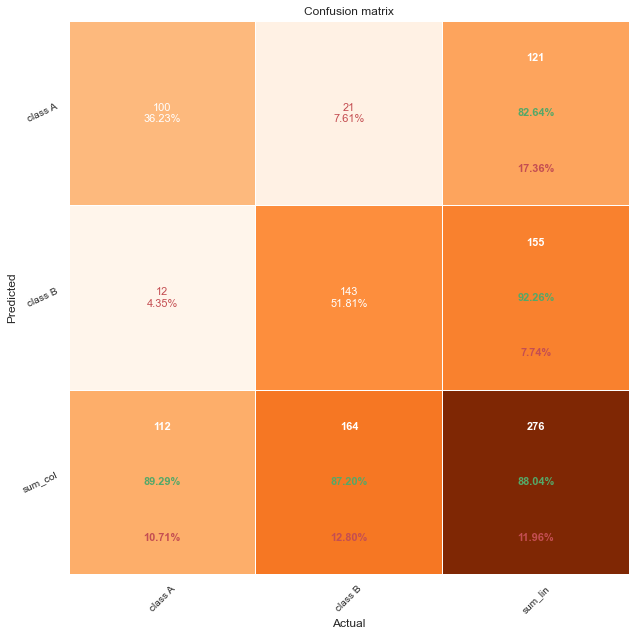

In [62]:
pp_matrix_from_data(y_test, test_preds)

### ROC Curve for Best Model

0.882404181184669


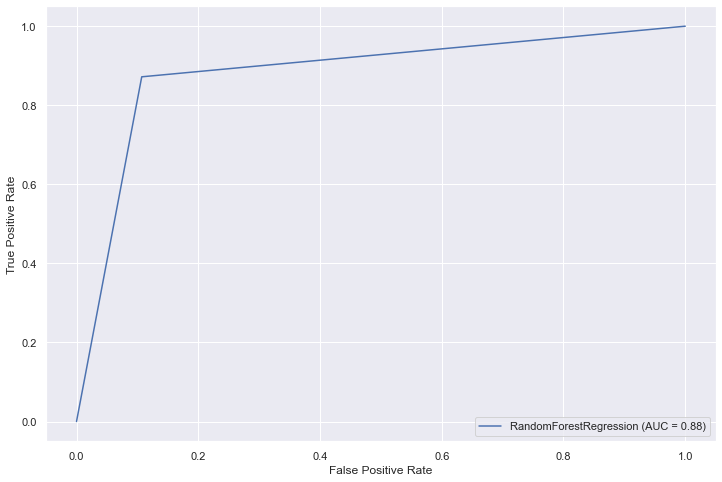

In [76]:
from sklearn.metrics import roc_curve, auc, RocCurveDisplay
fpr, tpr, thresholds = roc_curve(y_test, test_preds)
roc_auc = auc(fpr, tpr)
display = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc, estimator_name='RandomForestRegression')
display.plot()
print(roc_auc_score(y_test, test_preds))

Looking at the ROC Curve we can see that the area under the curve is above 50% therefore the model is a good fit for the data. We also obtained an ROC AUC score of 0.8824.